## Time series models

###### Additive

$$ Y^A_t = T_t + C_t + S_t + I_t $$

##### Multiplicative

$$ Y^M_t = T_t \times C_t \times S_t \times I_t $$

Time series can be made up of a number of components which combine additively or multiplicative

The components are:
- __Trend__ - $T_t$: any long term increase or drease in the data
- __Seasonal__ - $S_t$:fixed periodic patterns usually relating to times of day, week, year etc.
- __Cyclic__ - $C_t$: occurs when data shows rises and falls that are repeated but __not__ of a __fixed__ frequency. Examples include business cycles which will not have fixed periods. Often used for cycles longer than yearly, however I wonder if it is possible to use for short term cycles such as soiling
- __Irregular__ - $I_t$: Noise or residual left in signal

### Powerput from PV plants
The power output from PV plants is muliplicative in nature the trend is of the form:

$$Y_t = P_t(1 + \frac{(rt)}{365})$$

where $P_t$ is the irradiance, $r$ is the degradation rate (assumed to be negative) and $t$ is in units of days.

So our trend of interest is 

$$T_t  =  \left(1 + \frac{(rt)}{365}\right)$$

$P_t$ can be affected by weather, soiling and time of day/year. In decomposition methods we should be able to remove these factors.

For now I think we should assume that the degragtion rate is constant between for an entire time series.

A degradation rate of 0.1% corresponds to an r of -0.1/100. 

__Goal__: my initial goal isto achieve a RMSE error of 0.01% for the rate for each data set. 

$$RMSE in per cent = 100*\sqrt{(r_{true} - r_{calculated})^2}$$


Many methods for time series decomposition are  more suited to dealing with additive models

We can convert our multiplicative model to an additive model by using logarithms.

$$ y_t = log\left(Y^M_t\right) $$
$$ y_t = log\left( T_t \times C_t \times S_t \times I_t\right) $$
$$ y_t = log\left(T_t \right) + log\left(C_t\right) + log\left(S_t\right) + log\left(I_t\right) $$

If we consider the form of our trend we see that:

$$ log \left(T_t \right) = log\left(1 + \frac{(rt)}{365}\right) $$



### Unobserved Components

Assuming a time series can be broken into an number of additive effects; Trends, Seasons, Cycles and Regerssion effects

The model looks like:

$$y_t = \underbrace{u_t}_{\text{trend}} + \underbrace{\lambda_t}_{\text{seasonal}} + \underbrace{c_t}_{cycle} + \sum^{k}_{j=1}\underbrace{\beta_j x_{jt}}_{\text{explanatory}} + \underbrace{\epsilon_t}_{irregular}$$

Confusingly the trend is made of of two parts; the level and the trend. They are given by:
\begin{split}\begin{align}
\underbrace{\mu_{t+1}}_{\text{level}} & = \mu_t + \nu_t + \eta_{t+1} \qquad & \eta_{t+1} \sim N(0, \sigma_\eta^2) \\\\
\underbrace{\nu_{t+1}}_{\text{trend}} & = \nu_t + \zeta_{t+1} & \zeta_{t+1} \sim N(0, \sigma_\zeta^2) \\
\end{align}\end{split}
The level is corresponds to the intercept while trend corresponds to the slope. Further confusion the fitted model has a number of compontents. model.level I think corresponds to the changes in the slope and intercept while model.trend is a time series of how the trend changes.

For our data I have been using the code to separate the level/trend from the seasonality. You can tell the model to fit to a constant slope and intercept or schastictally changing slops or intercepts. The analysis I have done so far presummes constant unchanging slope.

__Unobserved components pipeline__
1. Remove night and clipping (flexible) from power signal
2. resample to "D"/"2D"/"5D" (unobserved components struggles over the whole series at daily rate. 5D average is fine for basic data however may be serious issue for soiling)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import csv
sns.set(rc={'figure.figsize':(11, 4)}, font_scale=1.5)

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data/')

sys.path.insert(1, '../src/data')

import make_dataset as ma_da
from import_data import import_df_from_zip_pkl


In [6]:
import_df_from_zip_pkl("../data/raw/synthetic_basic.zip", 0)

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.00000,1,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.00000,1,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.00000,1,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.00000,1,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.00000,1,1,4
...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00-05:00,-1.0,0.0,5.2,0.0,0.94148,1,1,1435
2019-12-31 23:56:00-05:00,-1.0,0.0,5.2,0.0,0.94148,1,1,1436
2019-12-31 23:57:00-05:00,-1.0,0.0,5.2,0.0,0.94148,1,1,1437


In [7]:
def preprocess(df, window):
    # window refers to the time period over which resampling will take place
    df_night = ma_da.remove_night_time_data(df)
    df_night_clip = ma_da.remove_clipping_with_flexible_window(df_night, verbose=False)

    df_post = df_night_clip.resample(window).mean()
    df_post["LogPower"] = np.log(df_post["Power"])
    
    return df_post


                            Unobserved Components Results                            
Dep. Variable:                      LogPower   No. Observations:                  366
Model:                           fixed slope   Log Likelihood                 626.237
                   + stochastic seasonal(73)   AIC                          -1250.473
Date:                       Fri, 04 Sep 2020   BIC                          -1246.796
Time:                               12:21:33   HQIC                         -1249.000
Sample:                           01-01-2015                                         
                                - 12-31-2019                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal     0.0007   7.14e-05     10.478      0.00

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/statsmodels/tsa/statespac

                            Unobserved Components Results                            
Dep. Variable:                      LogPower   No. Observations:                  366
Model:                   deterministic trend   Log Likelihood                1301.812
                   + stochastic seasonal(73)   AIC                          -2599.625
Date:                       Fri, 04 Sep 2020   BIC                          -2592.271
Time:                               12:21:48   HQIC                         -2596.679
Sample:                           01-01-2015                                         
                                - 12-31-2019                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  5.128e-06   2.82e-07     18.177      0

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/statsmodels/tsa/statespac

Calculated rate: -0.011795292097461108
True rate: -0.011703669078953137
error % per year: -0.00916230185079702
                               Unobserved Components Results                                
Dep. Variable:                             LogPower   No. Observations:                  366
Model:             local linear deterministic trend   Log Likelihood                1450.989
                          + stochastic seasonal(73)   AIC                          -2895.979
Date:                              Fri, 04 Sep 2020   BIC                          -2884.949
Time:                                      12:22:32   HQIC                         -2891.561
Sample:                                  01-01-2015                                         
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                       coef    std err          z   

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/statsmodels/tsa/statespac

Calculated rate: -0.014317037437911573
True rate: -0.011703669078953137
error % per year: -0.26133683589584356
                            Unobserved Components Results                            
Dep. Variable:                      LogPower   No. Observations:                  366
Model:                          smooth trend   Log Likelihood                1420.229
                   + stochastic seasonal(73)   AIC                          -2834.457
Date:                       Fri, 04 Sep 2020   BIC                          -2823.427
Time:                               12:23:20   HQIC                         -2830.039
Sample:                           01-01-2015                                         
                                - 12-31-2019                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/statsmodels/tsa/statespac

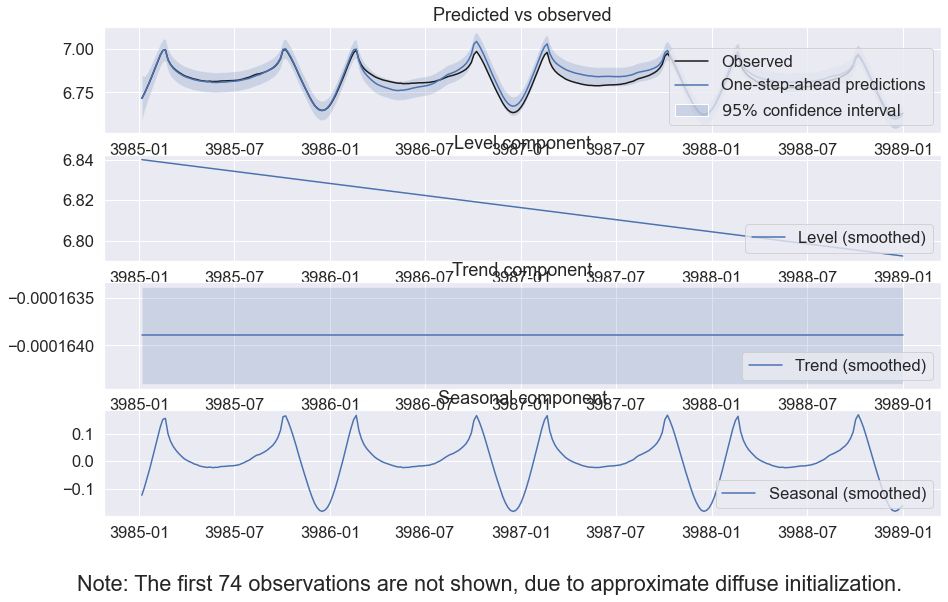

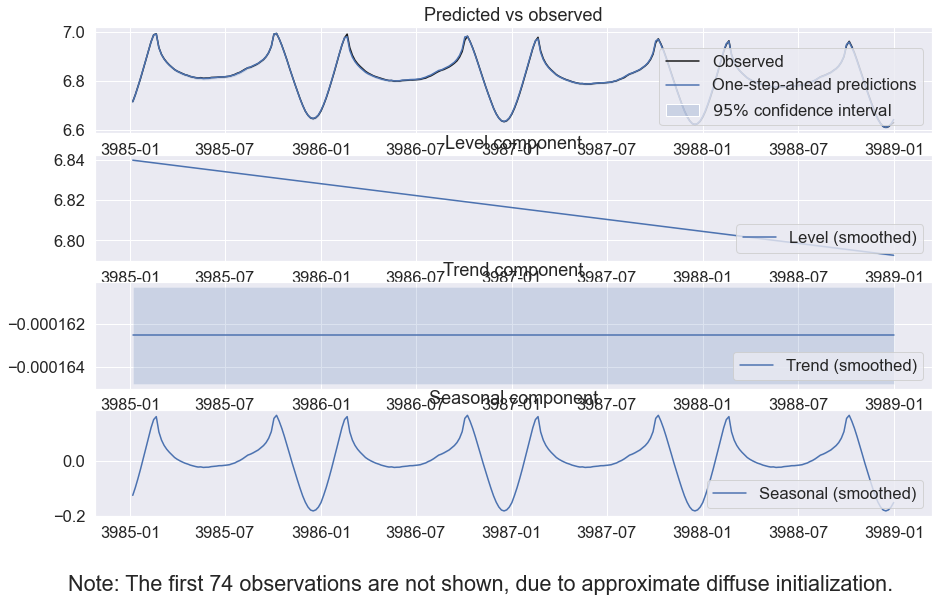

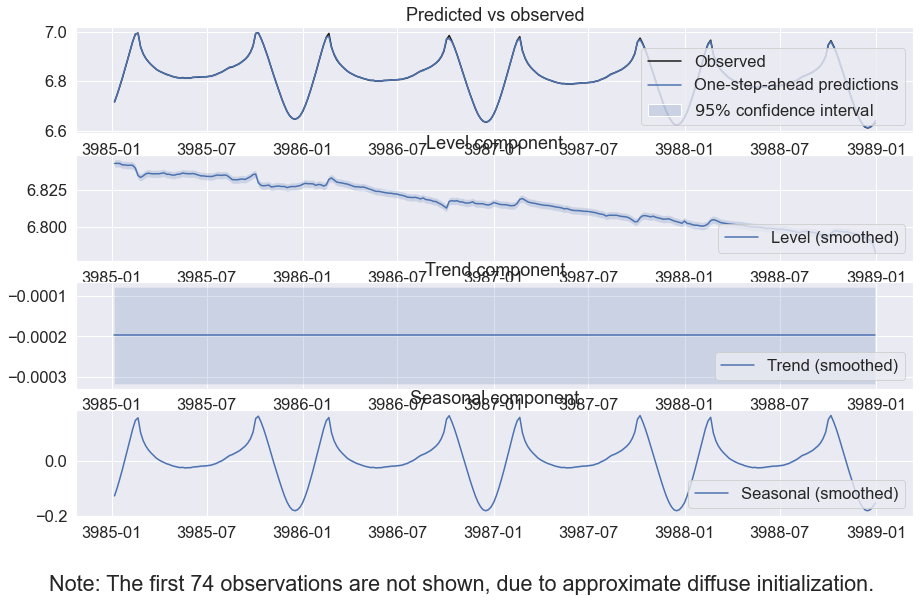

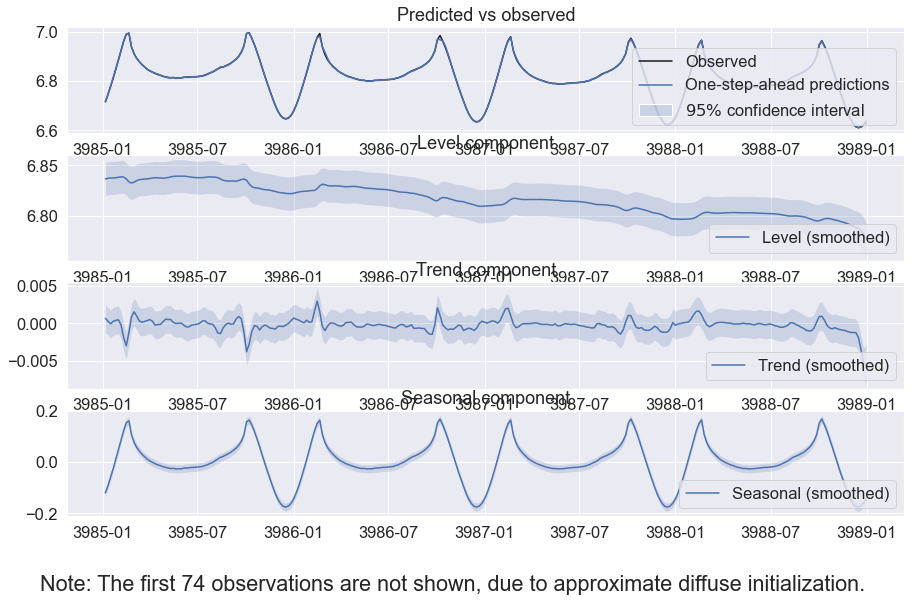

In [23]:
# by selecting different levels we can allow the trend and level to dyanmically change
# for more info on the settings https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html

levels = ["fixed slope", "dtrend", "lldtrend", "smooth trend"]
for level  in levels:
    for i in range(1):
        df = import_df_from_zip_pkl("../data/raw/synthetic_basic.zip", index=i)   
        # corresponds to the number of preprosccing windows in a year, ie. for 5D ~ 73, 1D ~ 365, etc.
        time_factor = 365//5 
        df_post_weekly = preprocess(basic_df, "5D")
        unrestricted_model_monthly = {
            'level': level, 'seasonal':time_factor, 
        }
        output_mod = sm.tsa.UnobservedComponents(df_post_weekly["LogPower"],  **unrestricted_model_monthly)
        output_res = output_mod.fit(method="powell", disp=False)
        
        ## to find the trend we make the assumption that the multiplicative trend is the form (1-r)^t rather than (1-rt)
        ## this means the trend found is log(1-r) since r is un changing we should find a constant trend
        ## log(1-r)^t = t * log(1-r), slope = log(1-r) = trend
        
        ## Unobsecved compneets has errror over the first portion of the returned trend
        
        ## time factor is used to give a yearly decay rate
        calculated_rate = np.exp(np.mean(output_res.trend["smoothed"][time_factor+1:])*time_factor)-1
        
        true_degrad_profile = df_post_weekly["Degradation"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.arange(true_degrad_profile.size)/time_factor, y=true_degrad_profile)
        true_rate = slope
        print(output_res.summary())
        output_res.plot_components(legend_loc='lower right', figsize=(15, 9))
        
        print("Calculated rate:", calculated_rate)
        print("True rate:", true_rate)
        print("error % per year:", 100*(calculated_rate-true_rate))
        

In [42]:
level = "fixed slope"

with open(r'basic_results.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(["data_set", "calc_rate", "true_rate", "error"])
      
    for i in range(0, 50):
        df = import_df_from_zip_pkl("../data/raw/synthetic_basic.zip", index=i)   
        # corresponds to the number of preprosccing windows in a year, ie. for 5D ~ 73, 1D ~ 365, etc.
        time_factor = 73
        df_post = preprocess(df, "5D")
        unrestricted_model = {
            'level': level, 'seasonal':time_factor, 
        }
        output_mod = sm.tsa.UnobservedComponents(df_post["LogPower"],  **unrestricted_model)
        output_res = output_mod.fit(method="powell", disp=False)
        
        ## to find the trend we make the assumption that the multiplicative trend is the form (1-r)^t rather than (1-rt)
        ## this means the trend found is log(1-r) since r is un changing we should find a constant trend
        ## log(1-r)^t = t * log(1-r), slope = log(1-r) = trend
        
        ## Unobsecved compneets has errror over the first portion of the returned trend
        
        ## time factor is used to give a yearly decay rate
        calculated_rate = np.exp(np.mean(output_res.trend["smoothed"][time_factor+1:])*time_factor)-1
        
        true_degrad_profile = df_post["Degradation"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.arange(true_degrad_profile.size)/time_factor, y=true_degrad_profile)
        true_rate = slope

        
        print("Calculated rate:", calculated_rate)
        print("True rate:", true_rate)
        print("error % per year:", 100*(calculated_rate-true_rate))
        
        writer.writerow([i, calculated_rate, true_rate, calculated_rate-true_rate])
        



Calculated rate: -0.011893150972948074
True rate: -0.011703669078953137
error % per year: -0.018948189399493713
Calculated rate: -0.01396845775694533
True rate: -0.013708248509811019
error % per year: -0.026020924713431037
Calculated rate: -0.010010282952258698
True rate: -0.009867721785456593
error % per year: -0.01425611668021045
Calculated rate: -0.01339269926743758
True rate: -0.013152308330872858
error % per year: -0.024039093656472166
Calculated rate: -0.011196944012693222
True rate: -0.01102837619394324
error % per year: -0.016856781874998242
Calculated rate: -0.0064929734478288426
True rate: -0.006400030386242078
error % per year: -0.009294306158676418
Calculated rate: -0.0058301936130538135
True rate: -0.005745546106653892
error % per year: -0.008464750639992132
Calculated rate: -0.012411125247438703
True rate: -0.012206560286597548
error % per year: -0.020456496084115573
Calculated rate: -0.012794481541565705
True rate: -0.012573301339947532
error % per year: -0.0221180201618

In [43]:
df = pd.read_csv("basic_results.csv")
100*np.sqrt((df["error"]**2).mean())

0.015219182386430467

In [46]:
level = "fixed slope"

with open(r'soil_results.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(["data_set", "calc_rate", "true_rate", "error"])
      
    for i in range(0, 50):
        df = import_df_from_zip_pkl("../data/raw/synthetic_soil.zip", index=i)   
        # corresponds to the number of preprosccing windows in a year, ie. for 5D ~ 73, 1D ~ 365, etc.
        time_factor = 52
        df_post = preprocess(df, "7D")
        unrestricted_model = {
            'level': level, 'seasonal':time_factor, 
        }
        output_mod = sm.tsa.UnobservedComponents(df_post["LogPower"],  **unrestricted_model)
        output_res = output_mod.fit(method="powell", disp=False)
        
        ## to find the trend we make the assumption that the multiplicative trend is the form (1-r)^t rather than (1-rt)
        ## this means the trend found is log(1-r) since r is un changing we should find a constant trend
        ## log(1-r)^t = t * log(1-r), slope = log(1-r) = trend
        
        ## Unobsecved compneets has errror over the first portion of the returned trend
        
        ## time factor is used to give a yearly decay rate
        calculated_rate = np.exp(np.mean(output_res.trend["smoothed"][time_factor+1:])*time_factor)-1
        
        true_degrad_profile = df_post["Degradation"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.arange(true_degrad_profile.size)/time_factor, y=true_degrad_profile)
        true_rate = slope

        
        print("Calculated rate:", calculated_rate)
        print("True rate:", true_rate)
        print("error % per year:", 100*(calculated_rate-true_rate))
        
        writer.writerow([i, calculated_rate, true_rate, calculated_rate-true_rate])
        



Calculated rate: 0.005317850051995032
True rate: -0.012064195796735707
error % per year: 1.7382045848730736
Calculated rate: -0.011553438913780467
True rate: -0.009661582664293485
error % per year: -0.18918562494869823
Calculated rate: 0.013428725384677431
True rate: -0.012102359475703229
error % per year: 2.5531084860380657
Calculated rate: 0.02829232335234022
True rate: -0.014911952640104593
error % per year: 4.320427599244481
Calculated rate: 0.010412639050100037
True rate: -0.008016527876076367
error % per year: 1.8429166926176404
Calculated rate: -0.02410139371819342
True rate: -0.012240947579083613
error % per year: -1.1860446139109808
Calculated rate: 0.013308981442456957
True rate: -0.008385721033654179
error % per year: 2.169470247611114
Calculated rate: -0.006134341262430509
True rate: -0.00821972267347723
error % per year: 0.208538141104672
Calculated rate: -0.008498003105375629
True rate: -0.012216938345147315
error % per year: 0.3718935239771686
Calculated rate: 0.01960743

In [47]:
df = pd.read_csv("soil_results.csv")
100*np.sqrt((df["error"]**2).mean())
# df.plot(x="calc_rate", y="true_rate", kind='scatter')
#df["error"].hist()

1.6023066228022254

In [48]:
level = "fixed slope"

with open(r'weather_results.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(["data_set", "calc_rate", "true_rate", "error"])
      
    for i in range(0, 50):
        df = import_df_from_zip_pkl("../data/raw/synthetic_weather.zip", index=i)   
        # corresponds to the number of preprosccing windows in a year, ie. for 5D ~ 73, 1D ~ 365, etc.
        time_factor = 52
        df_post = preprocess(df, "7D")
        unrestricted_model = {
            'level': level, 'seasonal':time_factor, 
        }
        output_mod = sm.tsa.UnobservedComponents(df_post["LogPower"],  **unrestricted_model)
        output_res = output_mod.fit(method="powell", disp=False)
        
        ## to find the trend we make the assumption that the multiplicative trend is the form (1-r)^t rather than (1-rt)
        ## this means the trend found is log(1-r) since r is un changing we should find a constant trend
        ## log(1-r)^t = t * log(1-r), slope = log(1-r) = trend
        
        ## Unobsecved compneets has errror over the first portion of the returned trend
        
        ## time factor is used to give a yearly decay rate
        calculated_rate = np.exp(np.mean(output_res.trend["smoothed"][time_factor+1:])*time_factor)-1
        
        true_degrad_profile = df_post["Degradation"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.arange(true_degrad_profile.size)/time_factor, y=true_degrad_profile)
        true_rate = slope

        
        print("Calculated rate:", calculated_rate)
        print("True rate:", true_rate)
        print("error % per year:", 100*(calculated_rate-true_rate))
        
        writer.writerow([i, calculated_rate, true_rate, calculated_rate-true_rate])
        


Calculated rate: -0.01301127116212808
True rate: -0.012885250542759668
error % per year: -0.012602061936841172
Calculated rate: -0.010315922993279325
True rate: -0.0019276605878367592
error % per year: -0.8388262405442566
Calculated rate: 0.005261498892582983
True rate: -0.00906567718155937
error % per year: 1.4327176074142352
Calculated rate: -0.012262039196986652
True rate: -0.007248201907159519
error % per year: -0.5013837289827133
Calculated rate: -0.018567968546703395
True rate: -0.005463729618853269
error % per year: -1.3104238927850127
Calculated rate: -0.01640315871162845
True rate: -0.0079403591898281
error % per year: -0.8462799521800352
Calculated rate: -0.0070529022183284384
True rate: -0.010025042477579389
error % per year: 0.29721402592509505
Calculated rate: -0.022809501050068848
True rate: -0.016242915828028073
error % per year: -0.6566585222040775
Calculated rate: -0.005954534482913498
True rate: -0.008406214900368804
error % per year: 0.24516804174553058
Calculated ra

In [49]:
df = pd.read_csv("weather_results.csv")
100*np.sqrt((df["error"]**2).mean())
# df.plot(x="calc_rate", y="true_rate", kind='scatter')
#df["error"].hist()

0.9663646526390984

<AxesSubplot:xlabel='calc_rate'>

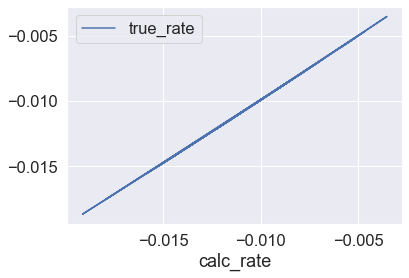

In [48]:
df.plot(x="calc_rate", y="true_rate")


In [89]:
0.0007870193072022635*12

0.009444231686427162

In [126]:
stats.linregress(x/12,(1+-0.00948)**(x/12))

LinregressResult(slope=-0.009353225256640616, intercept=0.9998929031742512, rvalue=-0.9999884228113473, pvalue=5.985692320775456e-106, stderr=6.7092729551910065e-06)

In [9]:
-0.009933342152112326**2

-9.867128631093152e-05

In [13]:
print(100*-0.021413342152112325)
print(-0.011479999999999999)

-2.1413342152112325
-0.011479999999999999


In [6]:
output_res.plot_components(legend_loc='lower right', figsize=(15, 9))

TypeError: plot_components() got an unexpected keyword argument 'egend_loc'